Importando bibliotecas

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np

Carregando o dataframe

In [111]:
df_real = pd.read_csv('data/healthcare-dataset-stroke-data.csv')
print(df_real['stroke'].value_counts())


stroke
0    4861
1     249
Name: count, dtype: int64


Equilibrando a base de dados, para que o número de amostras com AVC seja o mesmo que o número de amostras sem AVC

In [115]:
df = df_real.loc[:497]
print(df['stroke'].value_counts())

df = df.dropna()
df.replace(0, -1, inplace=True)
df.head()

stroke
1    249
0    249
Name: count, dtype: int64


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,-1,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,31112,Male,80.0,-1,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,-1,-1,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,-1,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,-1,-1,Yes,Private,Urban,186.21,29.0,formerly smoked,1


Convertendo os dados categóricos em numéricos

In [116]:
# bmi
# https://www.cdc.gov/obesity/basics/adult-defining.html#:~:text=If%20your%20BMI%20is%20less,falls%20within%20the%20obesity%20range.
bmi = df['bmi']

df['underweight'] = bmi< 18.5
df['healthy_weight'] = (18.5 <= bmi) & (bmi < 25)
df['overweight'] = (25 <= bmi) & (bmi < 30)
df['obesity'] = 30 <= bmi


# avg_glucose_level
# https://www.cdc.gov/diabetes/basics/getting-tested.html#:~:text=A%20fasting%20blood%20sugar%20level,higher%20indicates%20you%20have%20diabetes.
glucose = df['avg_glucose_level']
df['normal_glucose_level'] = glucose <= 99
df['prediabetes'] = (100 <= glucose) & (glucose <=125)
df['diabetes'] = 126 <= glucose

# age 
age = df['age']
df['children'] = age <= 12
df['teen'] = (13<=age ) & (age<=19)
df['adult'] = (20 <=age) & (age<=39)
df['middle_age'] = (40<=age) & (age<=59)
df['senior'] = 60 <= age 

df = pd.get_dummies(df, dtype=float)
df.replace(False, -1, inplace=True)
df.replace(True, 1, inplace=True)
df.replace(0, -1, inplace=True)
df.head(2)


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,underweight,healthy_weight,overweight,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,67.0,-1,1,228.69,36.6,1,-1,-1,-1,...,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0
2,31112,80.0,-1,1,105.92,32.5,1,-1,-1,-1,...,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0


In [117]:
# caracteríticas
X = df.drop(['id', 'stroke', 'age', 'avg_glucose_level', 'bmi'], axis=1)
X = X.astype('float64')

# resultados
y = df['stroke']
y = y.astype('float64')

Separando linhas de dados em treino e teste

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)
X_train,  X_test = X_train.to_numpy().T,  X_test.to_numpy().T
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()


função de acurácia utilizada

In [169]:
def accuracy(y_test, y_est):
    return np.mean(np.sign(y_test)==np.sign(y_est))


def acuracia_hipotese_nula(y_test):
    sem_avc = np.count_nonzero(y_test == -1)
    com_avc = np.count_nonzero(y_test == 1)
    maior = max(sem_avc, com_avc)
    return maior / len(y_test)


def tabela_relevancia(w_):
    df_ = pd.DataFrame()
    df_['features'] = X.columns
    df_['peso'] = w_
    df_.sort_values(by='peso', inplace=True, ascending=False)
    df_ = df_.reset_index()
    return df_[['features', 'peso']]


## Classificação linear

In [188]:
import autograd.numpy as np_ 
from autograd import grad

def loss( parametros ):
    w, b, pontos, val = parametros # parametros como vetores
    est = w.T @ pontos + b
    mse = np_.mean( (est - val)**2)

    return mse

g = grad(loss)

pontos = X_train
alvos = y_train

w = np.random.randn(X_train.shape[0],1)
b = 0.0
alpha = 10**-3

for n in range(10**5):
    grad_ = g( (w, b, pontos, alvos) )
    w -= alpha*grad_[0]
    b -= alpha*grad_[1]

w_linear = w
y_hat = w_linear.T @ X_test + b
acuracia_linear = accuracy(y_hat, y_test)
print(f'Acurácia: {acuracia_linear}')
print(f'Acurácia de hipótese nula: {acuracia_hipotese_nula(y_test)}')

Acurácia: 0.6872246696035242
Acurácia de hipótese nula: 0.5022026431718062


In [223]:
df_linear = tabela_relevancia(w_linear)
df_linear.head(30)

,features,peso
0,underweight,1.087012
1,obesity,1.041128
2,healthy_weight,1.024014
3,overweight,1.002153
4,heart_disease,0.188710
5,hypertension,0.151407
6,smoking_status_smokes,0.128673
7,work_type_Never_worked,0.119196
8,smoking_status_formerly smoked,0.113266
9,smoking_status_never smoked,0.044611


## Classificador por árvore

In [217]:
df_rotulo = y_train
df_features = X_train.T

In [166]:
tree = DecisionTreeClassifier(criterion='entropy')
tree.fit(df_features, df_rotulo)

DecisionTreeClassifier(criterion='entropy')

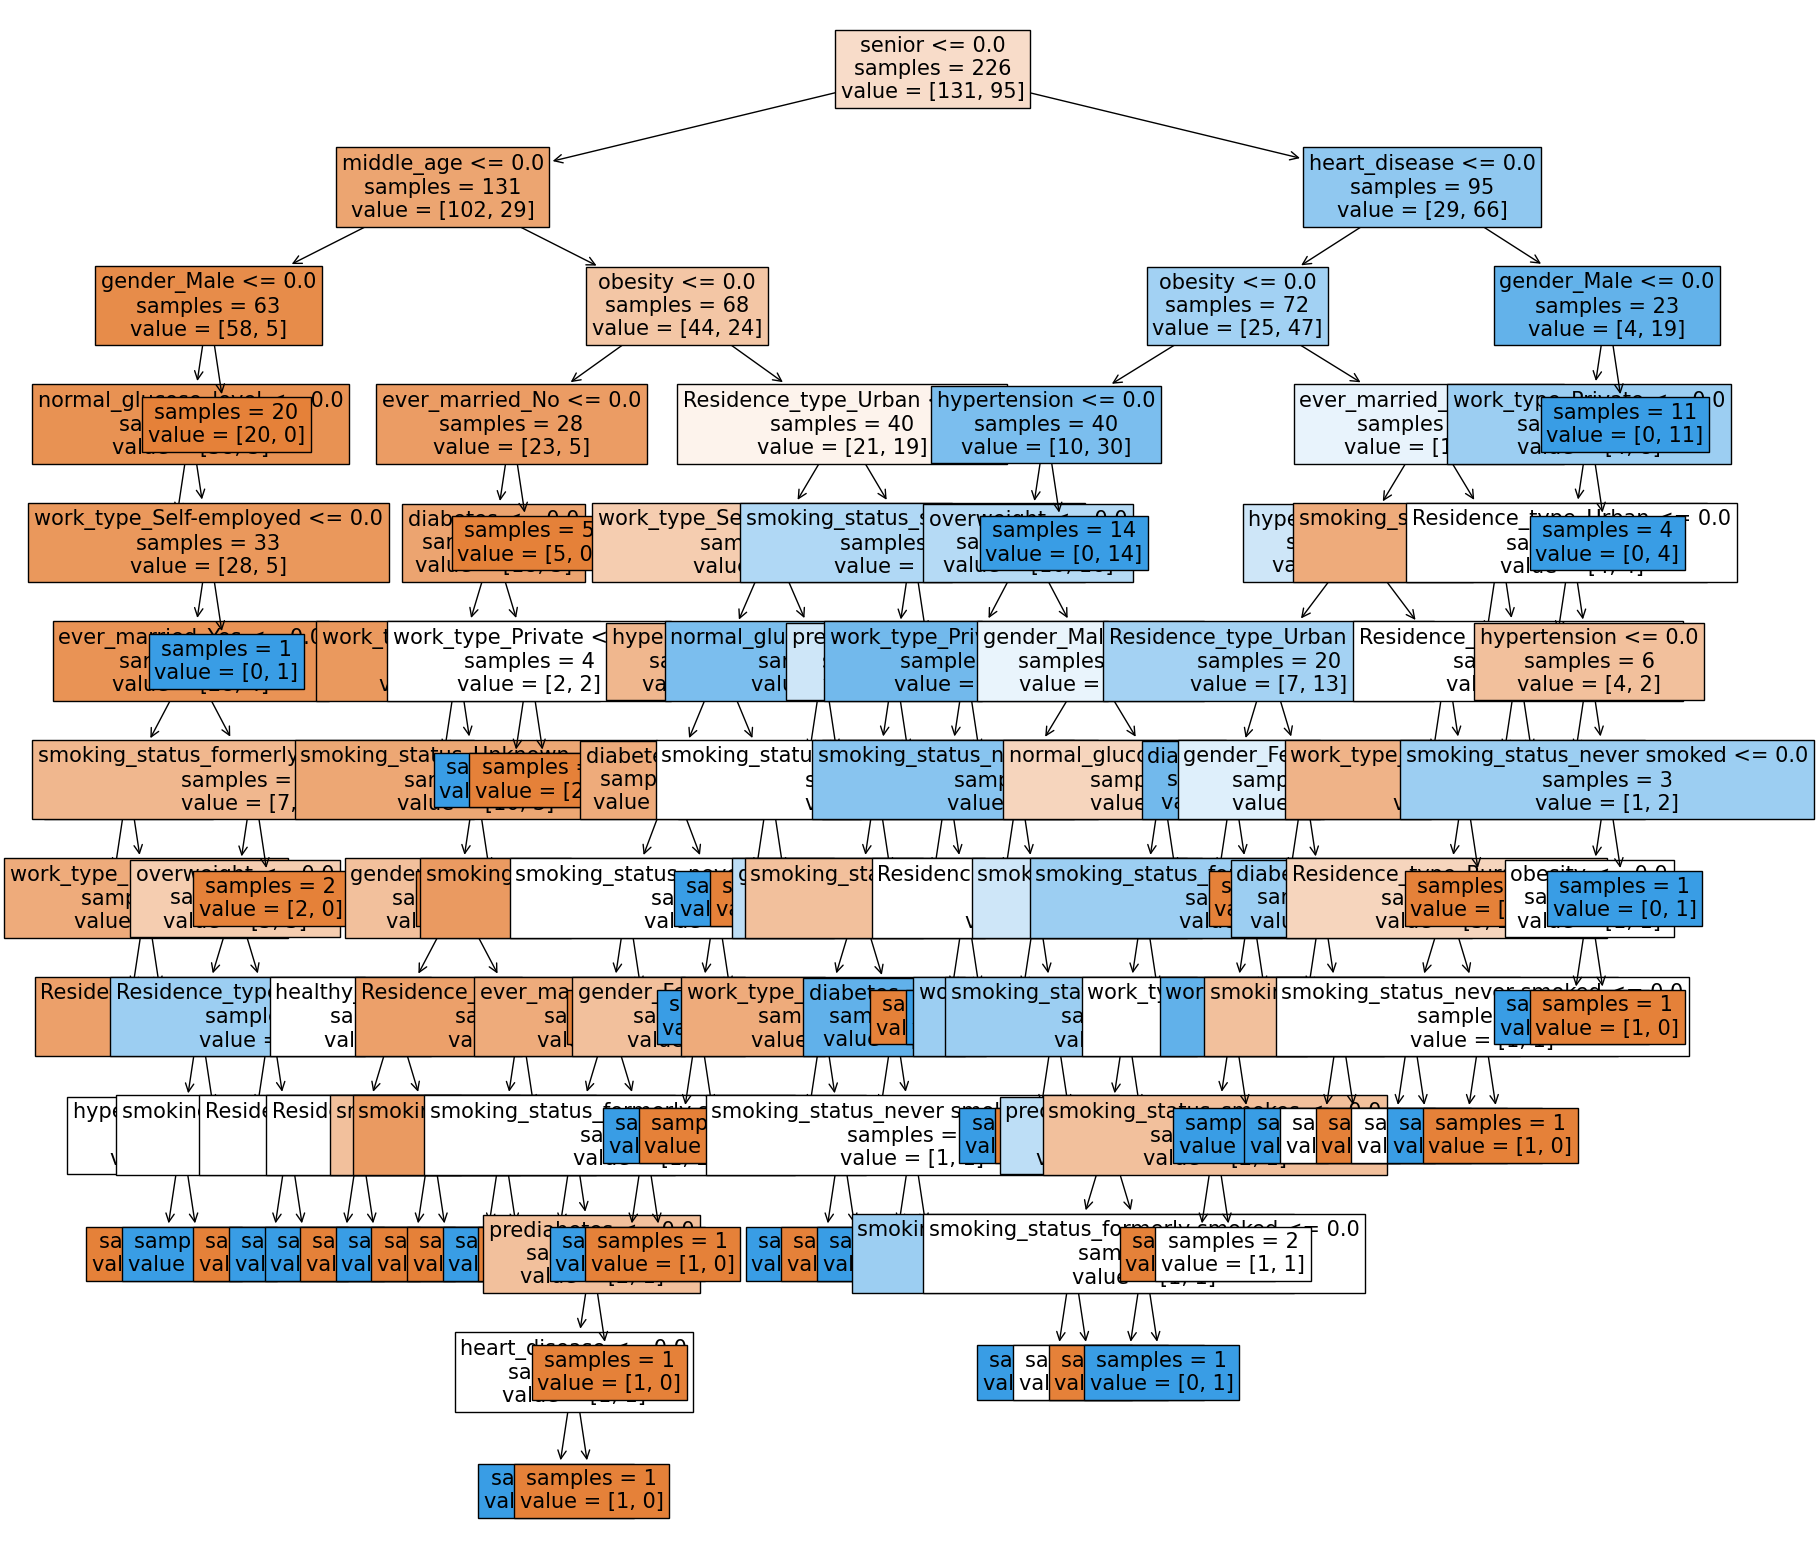

In [219]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure( figsize=(20,20) )
a = plot_tree(tree, feature_names=X.columns, fontsize=15, 
              node_ids=False, impurity=False, filled=True)
plt.savefig(fname='arvore_decisao')

In [221]:
w_arvore = tree.feature_importances_
y_est = w_arvore.T @ X_test 
acuracia_linear = accuracy(y_hat, y_test)
print(f'Acurácia: {acuracia_linear}')
print(f'Acurácia de hipótese nula: {acuracia_hipotese_nula(y_test)}')

Acurácia: 0.6872246696035242
Acurácia de hipótese nula:0.5022026431718062


In [222]:
df_arvore = tabela_relevancia(w_arvore)
df_arvore.head(30)

,features,peso
0,senior,0.178176
1,work_type_Private,0.089851
2,hypertension,0.076407
3,smoking_status_formerly smoked,0.064582
4,diabetes,0.061914
5,Residence_type_Urban,0.060729
6,obesity,0.057542
7,smoking_status_never smoked,0.053777
8,middle_age,0.052205
9,gender_Male,0.042970


### Classificação linear

A metodologia usada para a **classificação linear** utiliza a técnica de gradiente descendente para minimizar a função de perda, definida como a média dos erros quadráticos entre as saídas previstas e as saídas reais.

A função de perda é definida na função `loss()`, que recebe como entrada um vetor de parâmetros contendo o vetor de pesos `w`, o viés `b`, os dados de entrada pontos e os alvos val. A função calcula a saída estimada est usando os pesos e o viés, calcula o erro quadrático médio mse e retorna o valor do erro.

A função de gradiente `g` é definida usando a biblioteca autograd, que permite calcular automaticamente o gradiente da função de perda em relação aos parâmetros `w` e `b`.

Em seguida, os dados de treinamento são definidos como pontos e alvos, respectivamente, e os pesos `w` são inicializados aleatoriamente. O tamanho do passo alpha é definido como $10^-3$.

Em um loop, o gradiente da função de perda é calculado usando a função g e os pesos `w` e o viés `b` são atualizados com o tamanho do passo multiplicado pelo gradiente. O número de iterações é definido como $10^5$.

Após o treinamento, os pesos `w` e o viés b são usados para calcular a saída prevista `y_hat` para os dados de teste `X_test`, que é então comparada com os alvos `y_test` para calcular a acurácia do modelo. A função de acurácia `accuracy()` é usada para calcular a proporção de acertos em relação ao total de exemplos. Além disso, a acurácia da hipótese nula é calculada usando a função `acuracia_hipotese_nula()` para comparar com a acurácia do modelo.